# VLASS Tools

Here is the beginning of a compilation of tools for accessing and assessing VLASS quicklook data in small batches (up to a few hundred). Some of the tools can be modified for general radio astronomy tasks as well. If you have any questions or suggestions, please email Dillon Dong (ddong@nrao.edu).

## Dependencies:

#### General:
- astropy
- numpy
- matplotlib
- pandas

#### Downloading images:
- parse
- requests
- os
- wget

## Required files:
#### VLASS_image_metadata_{date}.csv 
- pre-compiled image and header info for all VLASS quicklook images as of {date}

## Main functions so far:

#### get_image_list(ra, dec):
- gets list of quicklook images that cover ra, dec
- gets observation dates and beam parameters from headers

#### download_image(image):
- downloads a quicklook image (~50MB)

#### make_cutout(ra, dec, image, size):
- gets array of pixel values near ra, dec
- option to save as png
- user specified size and normalization

## Coming soon:

- Catalog lookup
- Forced photometry
- Artifact filter
- Crossmatching


In [1]:
#General
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
from astropy.io import fits
from astropy.wcs import WCS
from astropy.modeling import models, fitting
from astropy.coordinates import SkyCoord, match_coordinates_sky
import pandas as pd

#Download VLASS images
from parse import *
import requests
import os
import wget

#Panstarrs cutouts
from astropy.table import Table
import requests
from PIL import Image
from io import BytesIO


In [2]:
#Helper functions

def check_ra_dec_in_bounds(ra,dec,ra_min,ra_max,dec_min,dec_max, image_size_deg = 1., return_edge_distances = True):
    if ra_min > ra_max:
        ra_min -= 360.
    
    if ra > 360.-image_size_deg: #Handle wraps at 359 - 1 deg
        ra -= 360.
    
    if ra_min < ra < ra_max:
        if dec_min < dec < dec_max:
            dist = np.min([np.abs(x) for x in [ra_min-ra, ra_max-ra, dec_min-dec, dec_max-dec]])*u.deg.to(u.arcsec)
            if return_edge_distances:
                return True, dist
            else:
                return True
            
    if return_edge_distances:
        dist = np.min([np.abs(x) for x in [ra_min-ra, ra_max-ra, dec_min-dec, dec_max-dec]])*u.deg.to(u.arcsec)
        return False, dist
    
    else:
        return False

def open_image_and_get_WCS(img):
    data = fits.getdata(img)
    header = fits.getheader(img)
    w = WCS(header)
    return w, data, header

def get_box(x,y, s):
    '''Input x, y coordinates, sidelength radius s. (x,y) can be float, s is an integer (e.g. 1, 3, 5 for a 1x1, 3x3, 5x5).
    Returns array of coordinates in a box of sidelength s around x,y'''
    radius = (s-1)/2
    xnearest = int(round(float(x)))
    ynearest = int(round(float(y)))
    xmin = xnearest-radius
    xmax = xnearest+radius+1
    ymin = ynearest-radius
    ymax = ynearest+radius+1

    return [xmin, xmax, ymin, ymax]


##########   Panstarrs functions
def getimages(ra,dec,filters="grizy"):
    
    """Query ps1filenames.py service to get a list of images
    
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """
    
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = f"{service}?ra={ra}&dec={dec}&filters={filters}"
    table = Table.read(url, format='ascii')
    return table


def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", color=False):
    
    """Get URL for images in the table
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    """
    
    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    table = getimages(ra,dec,filters=filters)
    url = (f"https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           f"ra={ra}&dec={dec}&size={size}&format={format}")
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[np.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    return url


def getcolorim(ra, dec, size=240, output_size=None, filters="grizy", format="jpg"):
    
    """Get color image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    url = geturl(ra,dec,size=size,filters=filters,output_size=output_size,format=format,color=True)
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im


def getgrayim(ra, dec, size=240, output_size=None, filter="g", format="jpg"):
    
    """Get grayscale image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filter = string with filter to extract (one of grizy)
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    if filter not in list("grizy"):
        raise ValueError("filter must be one of grizy")
    url = geturl(ra,dec,size=size,filters=filter,output_size=output_size,format=format)
    r = requests.get(url[0])
    im = Image.open(BytesIO(r.content))
    return im

In [3]:
#Main functions

def get_image_list(ra, dec, unit, metadata, names = None, ncheck = 10, min_edge_distance_arcsec = 5, verbose = False):
    '''
    Required input: 
    - ra, dec (can be array)
    - metadata (pandas table, read from VLASS_image_metadata_{date}.csv)
    
    Optional input:
    - name(s) (can be array, must be same length as ra, dec)
    
    Output: 
    - image_dict: dictionary of all images containing ra, dec within bounds and their edge distances
    
    Options:
    - ncheck = number of images to check per coordinate
    - min_edge_distance_arcsec = minimum distance from the edge of the image in arcsec
    '''
    
    if type(ra) == float:
        ra = [ra]
        dec = [dec]
    
    if names == None:
        names = ['Coord_'+str(i) for i in range(len(ra))]
        
    ra = np.array(ra)
    dec = np.array(dec)
    names = list(names)
    target_coords = SkyCoord(ra = ra, dec = dec, unit = unit)
    ra_deg, dec_deg = target_coords.ra.deg, target_coords.dec.deg
    
    meta_cat = SkyCoord(ra = np.array(metadata['central_ra'])*u.deg, dec = np.array(metadata['central_dec'])*u.deg)
    
    output = {}
    for n in range(ncheck):
        idx,d2d,d3d = match_coordinates_sky(target_coords, meta_cat, nthneighbor=n+1, storekdtree='tree')
        ra_min, ra_max, dec_min, dec_max, imagenames = [np.array(metadata.iloc[idx][x]) for x in ['ra_min','ra_max','dec_min','dec_max','Imagename']]
        for i, name in enumerate(names):
            try:
                output[name]
            except Exception as e:
                if verbose:
                    print(e)
                output[name] = {}
                output[name]['images'] = []
                output[name]['edge_distance_arcsec'] = []
                
            ra_i, dec_i = ra_deg[i], dec_deg[i]
            ra_min_ni, ra_max_ni, dec_min_ni, dec_max_ni = [arr[i] for arr in [ra_min, ra_max, dec_min, dec_max]]
            
            contained, edge_dist = check_ra_dec_in_bounds(ra_i,dec_i,ra_min_ni,ra_max_ni,dec_min_ni,dec_max_ni)
            if contained:
                if edge_dist > min_edge_distance_arcsec:
                    output[name]['images'].append(imagenames[i])
                    output[name]['edge_distance_arcsec'].append(edge_dist)
    
    return output
            
def download_image(image, outdir = None, name = None, verbose = False):
    '''
    Required input:
    - image (e.g., from output of get_image_list(). One image per function call.)

    Optional input:
    - outdir (directory to download image to. Default is current directory.)
    - name (user specified name of output image)
    - verbose (prints when downloads are attempted and whether they succeeded)
    
    Output:
    - Downloads image, returns path to image

    '''
    
    if outdir is None:
        outdir = os.getcwd()+'/'
    
    if name is None:
        name = image
    
    try:
        #'VLASS1.1.ql.T26t18.J232522+613000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits'
        epoch, tile, _ = parse('{}.ql.{}.{}',image)
        dirname, _ = parse('{}.I.{}',image)
        if '1.' in epoch:
            epoch += 'v2'           
        url = '/'.join(['https://archive-new.nrao.edu/vlass/quicklook',epoch,tile,dirname,image])
        #print(url)
        if os.path.isfile(outdir+name):
            if verbose:
                print('Skipping already downloaded file: ', name)
            pass
        else:
            if verbose:
                print('Downloading: ', name)
            dl = wget.download(url,out=outdir)
            print()
            print('Successfully downloaded: ', name)
            return outdir+name
            
    except Exception as e:
        print(e)
        return 
    
    

def make_cutout(ra,dec,unit,images,metadata, \
                calculate_stats = True, cutout_size = 61, stats_box_size = 15,\
                show = False, save = False, outdir = None, name = None, cmap = 'inferno',\
                normalization = 'linear', normalization_params = {'vmin':-0.5e-3,'vmax':1e-3}, show_circle = True, \
                panstarrs = False, overwrite = False, verbose = False):
    '''
    Required Input: 
    - ra, dec
    - unit (unit of ra, dec)
    - images (array of images corresponding to ra, dec. Must be full path.)
    - metadata (same as in get_image_list61.18744309)
    
    Optional Input:
    - calculate_stats (calculate basic summary statistics of image cutout T/F)
    - cutout_size (sidelength of image in pixels. 1 pixel = 1 arcsec)
    - stats_box_size (sidelength of box in which to calculate stats. 1 pixel = 1 arcsec)
    - show (show created images T/F)
    - save (save file T/F)
    - outdir (output directory for image cutouts)
    - name (user specified name. required if save = True)
    - cmap (matplotlib colormap, defaults to inferno)
    - normalization (renormalize colorscale)
    - normalization_params (parameters for normalization. Currently only linear supported, defaults to min value -0.5mJy, max 1mJy)
    - show_circle (show circle at ra, dec)
    - panstarrs (download panstarrs image T/F)
    - overwrite (T/F overwrite previous image if it exists)
    - verbose
    
    Outputs:
    - returns arrays of pixel values from image cutouts
    - if save = True, creates png cutout in outdir
    '''
    
    if show == False and save == False and calculate_stats == False:
        print('No operations requested')
        return
    
    #Setup
    c = SkyCoord(ra = ra, dec = dec, unit = unit)
    ra = c.ra.deg
    dec = c.dec.deg
    
    if name == None:
        name = 'cutout_'+c.to_string('hmsdms', sep = ':', precision = 1)
    
    if show or save:
        buffer = 0
        if panstarrs:
            buffer += 1
        
        figsize = (5*len(images)+buffer,6)
        fig, axes = plt.subplots(ncols = len(images)+buffer, figsize = figsize)
    
    #Get cutouts and add to figure
    max_pixs = []
    for i, img in enumerate(images):
        if verbose: print('Attempting cutout for: ', img)
        
        try:
            #Read in full image
            data = fits.getdata(img)
            imsize = np.shape(data)[-1]+1
            f = fits.open(img)
            w = WCS(f[0].header)
            xpix, ypix, _, _ = w.wcs_world2pix(ra, dec, 3000000000.0, 1.0, 0)

            #Get stat box data, calculate stats
            if calculate_stats:
                xmin_stat, xmax_stat, ymin_stat, ymax_stat = [int(x) for x in get_box(xpix, ypix, stats_box_size)]
                #Handle cases around image edge
                xmin_stat, ymin_stat = [np.max([0,xmin_stat]),np.max([0,ymin_stat])]
                xmax_stat, ymax_stat = [np.min([xmax_stat,imsize]),np.min([ymax_stat,imsize])]
                stat_box_data = data[0][0][ymin_stat:ymax_stat,xmin_stat:xmax_stat]
                stat_max = np.max(stat_box_data)
                max_pixs.append(stat_max)
                

            #Make image cutout
            if show or save:
                ax = axes[i]
                ax.axis('off')
                xmin, xmax, ymin, ymax = [int(x) for x in get_box(xpix, ypix, cutout_size)]
                xmin,ymin = [np.max([0,xmin]),np.max([0,ymin])]
                xmax,ymax = [np.min([xmax,imsize]),np.min([ymax,imsize])]

                box_data = data[0][0][ymin:ymax,xmin:xmax]

                if calculate_stats:
                    p16,p50,p84 = [x*1000 for x in np.percentile(box_data,[16,50,84])]
                    plus_err = str(round(p84-p50,2))
                    minus_err = str(round(p50-p16,2))
                    p50 = str(round(p50,2))

                if normalization == 'linear':
                    vmin, vmax = normalization_params['vmin'], normalization_params['vmax']
                    norm = mpl.colors.Normalize(vmin = vmin, vmax = vmax)
                    ax.imshow(box_data, cmap = cmap, norm = norm, origin = 'lower')

                else:
                    ax.imshow(box_data, cmap = cmap, origin = 'lower')

                epoch, _ = parse('{}.ql{}',img)
                timestamp = metadata[metadata['Imagename'] == img]['Obs-time'].iloc[0]
                subtitle_str = epoch +'    '+ timestamp
                if calculate_stats:
                    subtitle_str+= '\n Median (mJy) = '+str(p50) + ' (+'+plus_err+')'+' (-'+minus_err+')'
                
                ax.set_title(subtitle_str)

                if show_circle:
                    center = (cutout_size-1)/2
                    center_x = xpix - xmin
                    center_y = ypix - ymin
                    ax.scatter(center_x, center_y, color = 'none', edgecolor ='blue', s = 500)
                    
        except Exception as e:
            if verbose: print(e)
        
    
    if panstarrs:
        ax = axes[len(images)]
        ax.axis('off')
        cim = getcolorim(ra,dec,size=(cutout_size-1)*4, filters = 'grz')
        ax.imshow(cim)
        ax.set_title('Panstarrs grz')
        if show_circle == True:
            ax.scatter(center*4, center*4, color = 'none', edgecolor ='blue', s = 500)
    
    if calculate_stats:
        title_str = name + '\n'  \
        + c.to_string('hmsdms',sep=':',precision = 3) + '\n'\
        'max pix (mJy): '+'    '.join([str(round(x,3)) for x in np.array(max_pixs)*1000]) 
    else:
        title_str = name + '\n' + c.to_string('hmsdms',sep=':',precision = 3)
    
    plt.suptitle(title_str)
    plt.tight_layout()
    
    #Save png
    if save:
        if outdir is None:
            outdir = os.getcwd()+'/'
        
        plt.savefig(outdir+name.replace(' ','_')+'.png')
        
    if show:
        plt.show()
    
    plt.close(fig)
    
    if calculate_stats:
        return max_pixs, box_data
    
    else:
        return box_data



In [4]:
#Example: cutouts of three sources

ra_list = [351.19888187,15.84272517,38.4455611,182.5056167]
dec_list = [61.18744309,62.36603842,-1.024547878,49.94636811]
name_list = ['V1405 Cas','Wolf 47','AGN z=0.05','VT 1210+4956']
unit = (u.deg,u.deg)
#unit = (u.hourangle,u.deg)

metadata = pd.read_csv('VLASS_image_metadata_2023-06-05.csv')
metadata

,Imagename,Epoch,Tile,Phasecenter,Version,Obs-time,central_ra,central_dec,ra_min,ra_max,dec_min,dec_max,bmaj,bmin,bpa
0,VLASS1.1.ql.T01t01.J000228-363000.10.2048.v2.I...,VLASS1.1,T01t01,J000228-363000,v2,2018-02-07T22:38:34.124999,0.617981,-36.500203,359.974899,1.261063,-37.017148,-35.983259,0.001118,0.000438,37.188366
1,VLASS1.1.ql.T01t01.J000230-373000.10.2048.v2.I...,VLASS1.1,T01t01,J000230-373000,v2,2018-02-07T22:09:18.675000,0.626040,-37.500209,359.974444,1.277636,-38.017153,-36.983264,0.000959,0.000486,34.577499
2,VLASS1.1.ql.T01t01.J000232-383000.10.2048.v2.I...,VLASS1.1,T01t01,J000232-383000,v2,2018-02-07T21:36:21.375000,0.634511,-38.500219,359.973968,1.295053,-39.017163,-37.983274,0.000855,0.000557,28.787424
3,VLASS1.1.ql.T01t01.J000234-393000.10.2048.v2.I...,VLASS1.1,T01t01,J000234-393000,v2,2018-02-07T21:15:47.025001,0.643412,-39.500236,359.973467,1.313357,-40.017180,-38.983292,0.000820,0.000645,10.075943
4,VLASS1.1.ql.T01t01.J000724-363000.10.2048.v1.I...,VLASS1.1,T01t01,J000724-363000,v1,2018-02-07T22:38:02.625001,1.854053,-36.500202,1.210971,2.497135,-37.017146,-35.983257,0.001093,0.000448,36.742729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83267,VLASS3.1.ql.T32t01.J105926+863000.10.2048.v1.I...,VLASS3.1,T32t01,J105926+863000,v1,2023-02-15T03:32:35.250000,164.860785,86.500031,156.392948,173.328622,85.983087,87.016976,0.001100,0.000626,71.476471
83268,VLASS3.1.ql.T32t01.J110528+853000.10.2048.v1.I...,VLASS3.1,T32t01,J110528+853000,v1,2023-02-15T04:05:32.099999,166.369944,85.500041,159.781171,172.958717,84.983097,86.016986,0.001067,0.000615,64.195244
83269,VLASS3.1.ql.T32t01.J114355+873000.10.2048.v1.I...,VLASS3.1,T32t01,J114355+873000,v1,2023-02-15T03:10:50.700000,175.985309,87.500003,164.134043,187.836576,86.983058,88.016947,0.001125,0.000627,89.561371
83270,VLASS3.1.ql.T32t01.J114403+863000.10.2048.v1.I...,VLASS3.1,T32t01,J114403+863000,v1,2023-02-15T03:32:44.249999,176.015168,86.500013,167.547375,184.482960,85.983068,87.016957,0.001119,0.000627,82.983910


In [5]:
#Get images that contain source
image_dict = get_image_list(ra_list, dec_list, unit, metadata, names = name_list, verbose = True)
image_dict

'V1405 Cas'
'Wolf 47'
'AGN z=0.05'
'VT 1210+4956'


{'V1405 Cas': {'images': ['VLASS1.1.ql.T26t18.J232522+613000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits',
   'VLASS3.1.ql.T26t18.J232522+613000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits',
   'VLASS2.1.ql.T26t18.J232522+613000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits'],
  'edge_distance_arcsec': [735.7209224523558,
   735.7200013639982,
   735.6685790813231]},
 'Wolf 47': {'images': ['VLASS2.1.ql.T26t01.J010354+623000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits',
   'VLASS1.1.ql.T26t01.J010354+623000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits',
   'VLASS3.1.ql.T26t01.J010354+623000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits'],
  'edge_distance_arcsec': [1378.6029138512135,
   1378.6437393809733,
   1378.6415566379503]},
 'AGN z=0.05': {'images': ['VLASS1.1.ql.T10t04.J023400-013000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits',
   'VLASS2.1.ql.T10t04.J023400-013000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits',
   'VLASS3.1.ql.T10t04.J023400-013000.10.2048.v1.I.iter

In [6]:
#Download images from all 3 epochs
for name in name_list:
    images = image_dict[name]['images']
    for image in images:
        download_image(image, verbose = True)

Skipping already downloaded file:  VLASS1.1.ql.T26t18.J232522+613000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
Skipping already downloaded file:  VLASS3.1.ql.T26t18.J232522+613000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
Skipping already downloaded file:  VLASS2.1.ql.T26t18.J232522+613000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
Skipping already downloaded file:  VLASS2.1.ql.T26t01.J010354+623000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
Skipping already downloaded file:  VLASS1.1.ql.T26t01.J010354+623000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
Skipping already downloaded file:  VLASS3.1.ql.T26t01.J010354+623000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
Skipping already downloaded file:  VLASS1.1.ql.T10t04.J023400-013000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
Skipping already downloaded file:  VLASS2.1.ql.T10t04.J023400-013000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
Skipping already downloaded file:  VLASS3.1.ql.T10t04.J023400-013000.10.2048.v1.

Attempting cutout for:  VLASS1.1.ql.T26t18.J232522+613000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
Attempting cutout for:  VLASS2.1.ql.T26t18.J232522+613000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
Attempting cutout for:  VLASS3.1.ql.T26t18.J232522+613000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits


Set OBSGEO-B to    34.078827 from OBSGEO-[XYZ].
Set OBSGEO-H to     2115.607 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set MJD-END to 59082.330349 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60006.705484 from DATE-END'. [astropy.wcs.wcs]


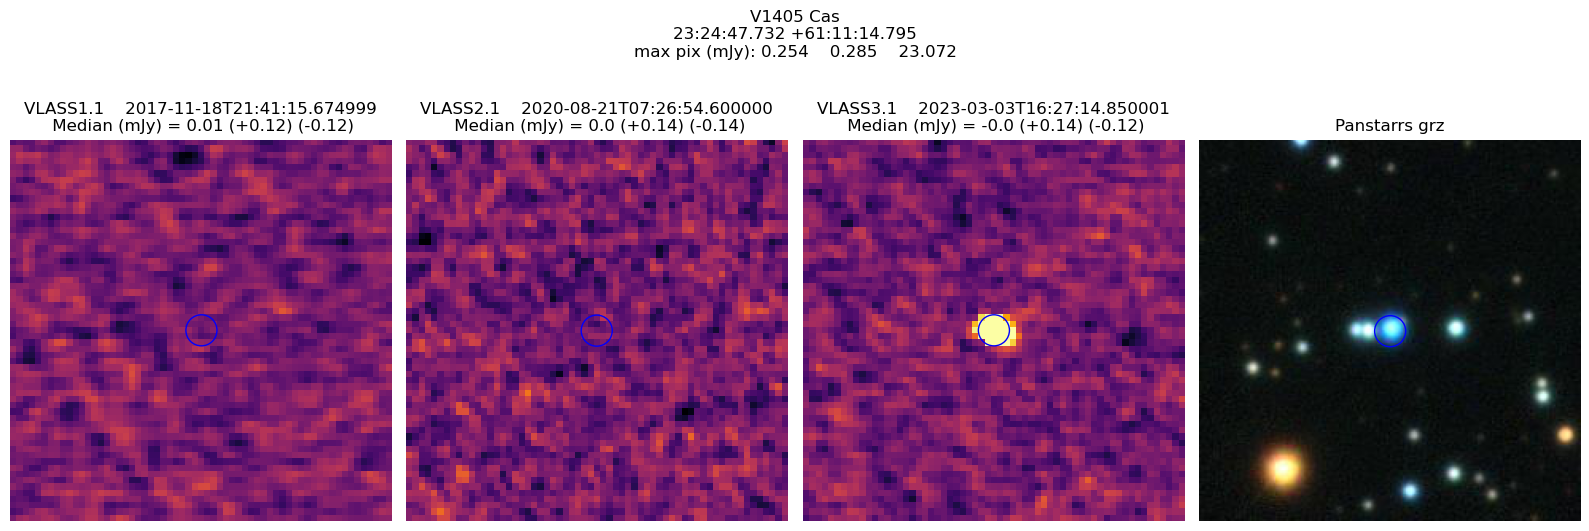

Attempting cutout for:  VLASS1.1.ql.T26t01.J010354+623000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
Attempting cutout for:  VLASS2.1.ql.T26t01.J010354+623000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
Attempting cutout for:  VLASS3.1.ql.T26t01.J010354+623000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits


Set MJD-END to 59082.421625 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60006.792391 from DATE-END'. [astropy.wcs.wcs]


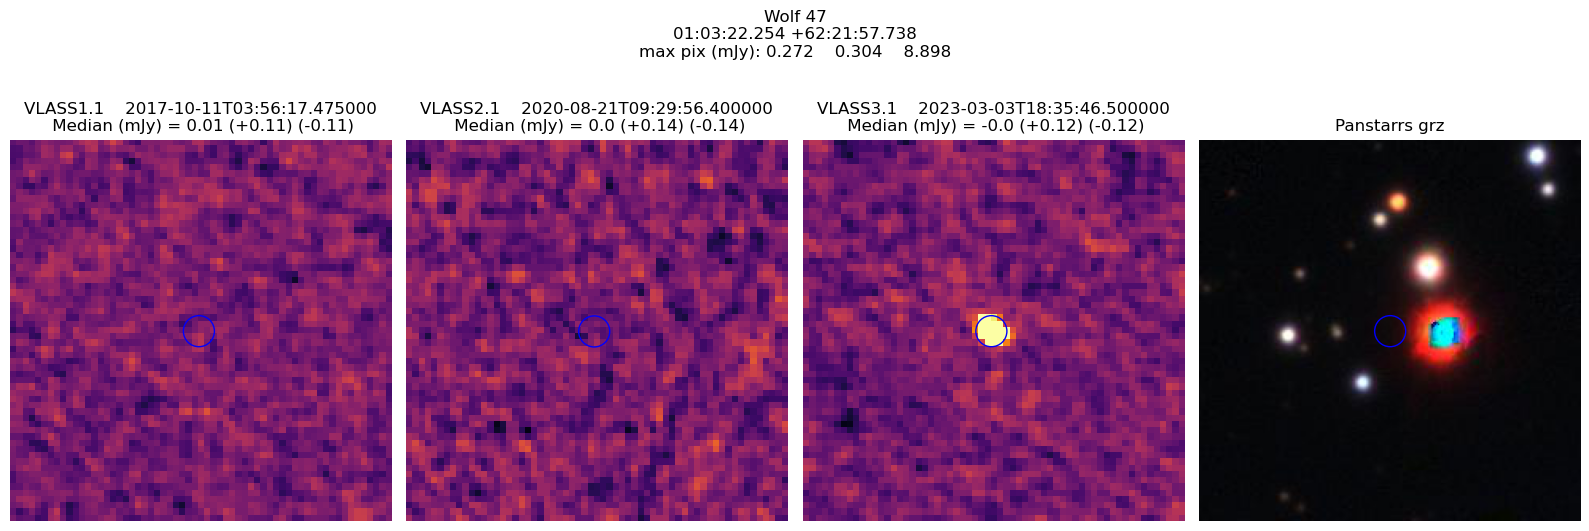

Attempting cutout for:  VLASS1.1.ql.T10t04.J023400-013000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
Attempting cutout for:  VLASS2.1.ql.T10t04.J023400-013000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
Attempting cutout for:  VLASS3.1.ql.T10t04.J023400-013000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits


Set MJD-END to 59118.409875 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 60010.960349 from DATE-END'. [astropy.wcs.wcs]


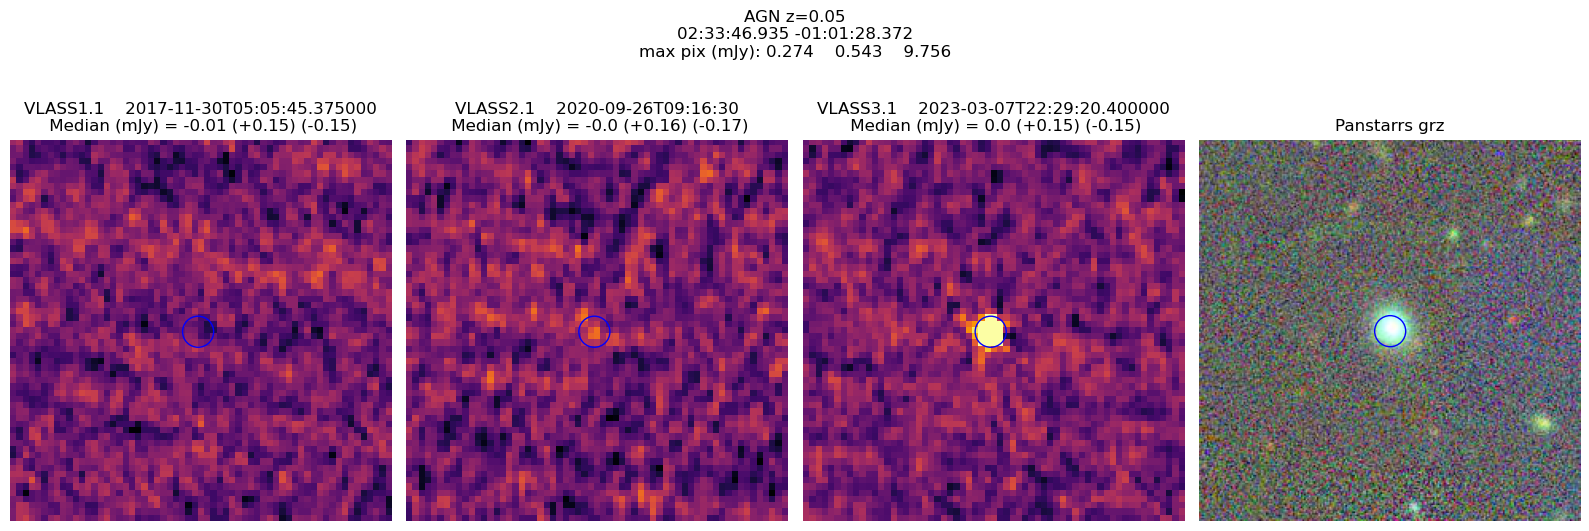

Attempting cutout for:  VLASS1.1.ql.T23t13.J120908+493000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
Attempting cutout for:  VLASS2.1.ql.T23t13.J120908+493000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits
Attempting cutout for:  VLASS3.1.ql.T23t13.J120908+493000.10.2048.v1.I.iter1.image.pbcor.tt0.subim.fits


Set MJD-END to 59062.962625 from DATE-END'. [astropy.wcs.wcs]
Set MJD-END to 59979.297146 from DATE-END'. [astropy.wcs.wcs]


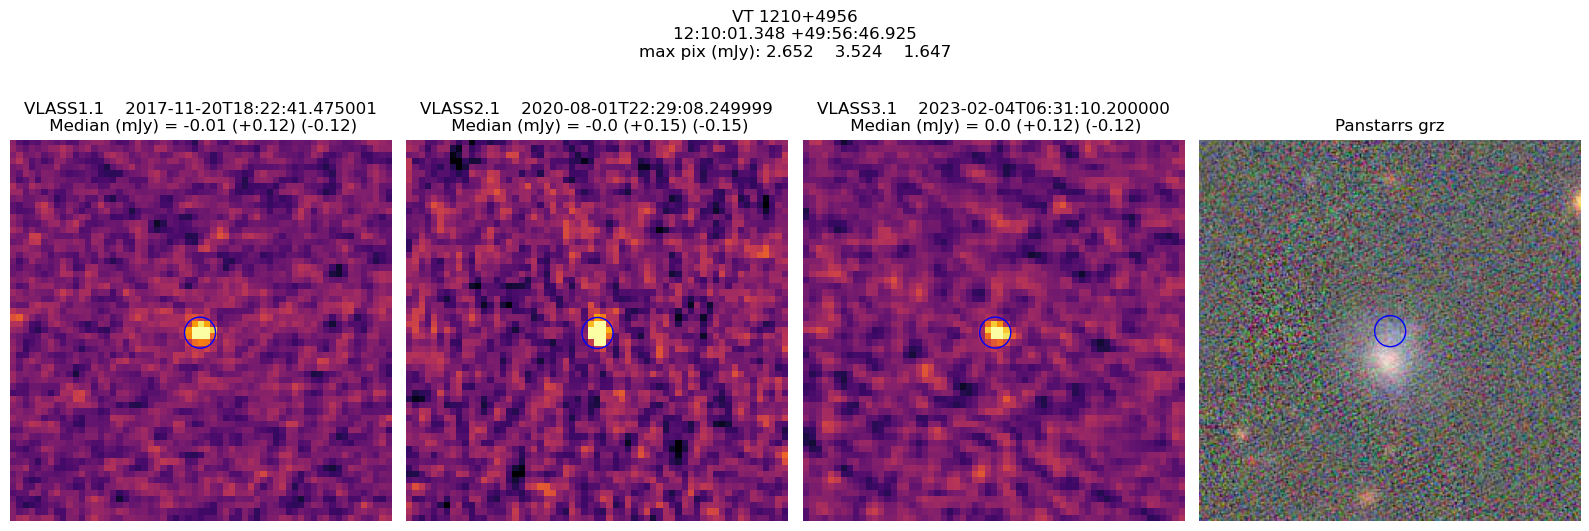

In [7]:
#Putting it all together

for i, ra in enumerate(ra_list):
    dec = dec_list[i]
    name = name_list[i]
    images = sorted(image_dict[name]['images'])
    make_cutout(ra,dec,unit,images,metadata = metadata,name = name,calculate_stats = True, show=True,save=True,panstarrs=True,verbose=True)
    
